# Task 3.1: Pytorch

### 1. Import libs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import time
import pickle
import math
import itertools
import copy

from torch.utils.tensorboard import SummaryWriter

### 2. Config

In [134]:
# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper params
batch_size = 32
num_epochs = 50

# Random seed
seed = 2022
torch.random.manual_seed(seed)
np.random.seed(2022)

# Tensorboard writer
writer = SummaryWriter("runs/multilabels")

### 3. Load Data

In [59]:
# !mkdir data
# !cp -r /home/tungnguyendinh/.fastai/data/pascal_2007/ ./data/pascal_2007
# !ls ./data/pascal_2007

In [60]:
# Data directory
data_dir = './data/pascal_2007'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
# Save directory
save_dir = './saved'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# Image directory
train_img_dir = os.path.join(data_dir, 'train')
test_img_dir = os.path.join(data_dir, 'test')

# Annotaion file
train_anno_file = os.path.join(data_dir, 'train.csv')
test_anno_file = os.path.join(data_dir, 'test.csv')

In [61]:
# Load images and labels
def load_images_and_labels(image_dir, anno_path, is_train=True):
    # Load anno files
    anno = pd.read_csv(anno_path).values  
    
    if is_train:
        # Train set
        train_images = []
        train_labellists = []
        
        # Valid set
        valid_images = []
        valid_labellists = []
        
        # Split train and valid set
        train_anno = anno[~ anno[:, 2].astype(np.bool8)][:, :2]
        valid_anno = anno[anno[:, 2].astype(np.bool8)][:, :2]
        
        # Load training set
        print('Loading training set')
        print('-'*10)
        for filename, labellist in train_anno:
            
            image = plt.imread(os.path.join(image_dir, filename))
            train_images.append(image)
            
            train_labellists.append(labellist.split(' '))
        
        # Load valid set
        print('Loading validate set')
        print('-'*10)
        for filename, labellist in valid_anno:
            
            image = plt.imread(os.path.join(image_dir, filename))
            valid_images.append(image)
            
            valid_labellists.append(labellist.split(' '))
        
        return (train_images, train_labellists), (valid_images, valid_labellists)
    
    else:
        # Test set
        test_images = []
        test_labellists = []
        
        # Load test set
        print('Loading test set')
        print('-'*10)
        for filename, labellist in anno:
            
            image = plt.imread(os.path.join(image_dir, filename))
            test_images.append(image)
            
            test_labellists.append(labellist.split(' '))
        
        return (test_images, test_labellists)
    

(train_images, train_labels), (valid_images, valid_labels) = load_images_and_labels(train_img_dir, train_anno_file, True)
(test_images, test_labels) = load_images_and_labels(test_img_dir, test_anno_file, False)
    

Loading training set
----------
Loading validate set
----------
Loading test set
----------


In [62]:
# Dataset info
print('Train set: ', len(train_images))
print('Valid set: ', len(valid_images))
print('Test set: ', len(test_images))

Train set:  2501
Valid set:  2510
Test set:  4952


Average image height: 383.87
Average image width: 471.98


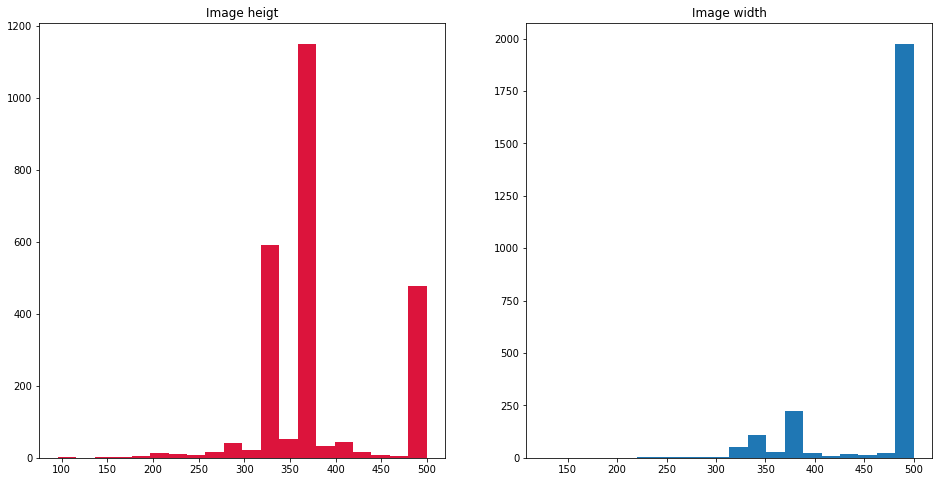

In [63]:
heights = []
widths = []

for image in train_images:
    height, width, channels = image.shape
    heights.append(height)
    widths.append(width)
    
print('Average image height: {:.2f}'.format(np.array(heights).mean()))
print('Average image width: {:.2f}'.format(np.array(widths).mean()))
    
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Image heigt')
plt.hist(heights, bins=20, color='crimson')

plt.subplot(1, 2, 2)
plt.title('Image width')
plt.hist(widths, bins=20)
plt.show()

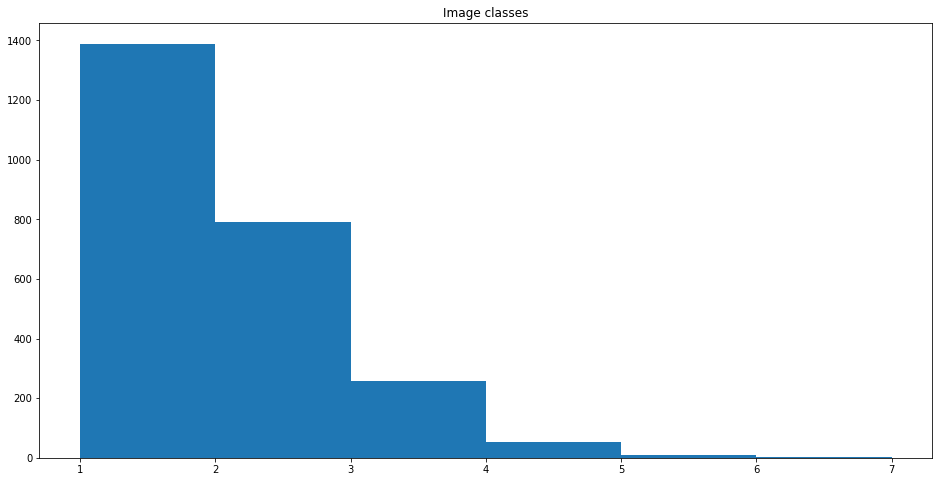

Average number of label per image: 1.61


In [64]:
num_image_classes = []

for labellist in train_labels:
    num_image_classes.append(len(labellist))


plt.figure(figsize=(16, 8))
plt.title('Image classes')
plt.hist(num_image_classes, bins=6)
plt.show()

print('Average number of label per image: {:.2f}'.format(sum(num_image_classes) / len(num_image_classes)))


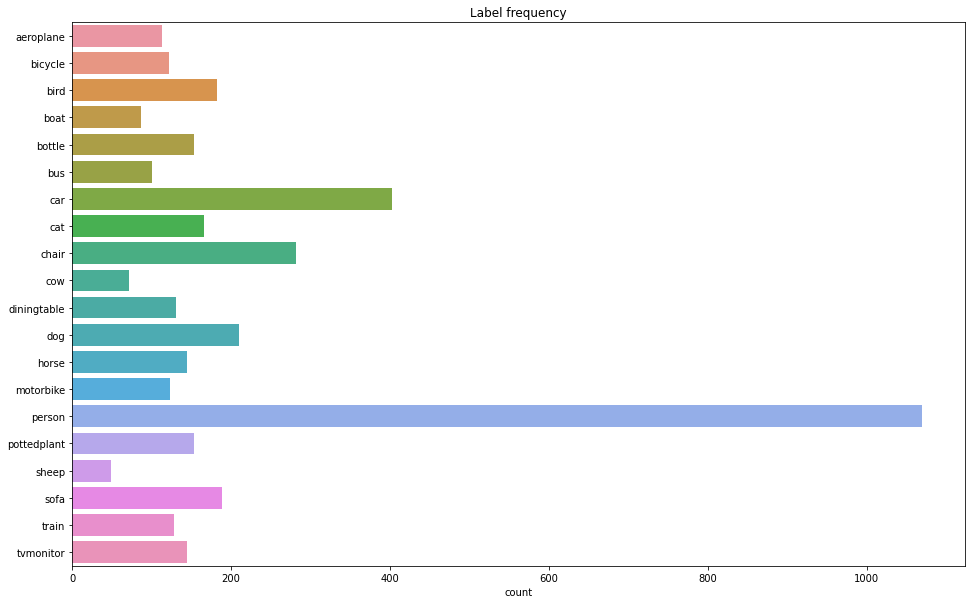

In [65]:
list_labels = list (itertools.chain(*train_labels))
plt.figure(figsize=(16, 10))
sns.countplot(y=sorted(list_labels), orient='v').set(title='Label frequency')
plt.show()

### 4. Dataset and DataLoader

In [66]:
# All labels
labels = []

for labellist in train_labels:
    labels = labels + labellist
    
labels = sorted(list(set(labels)))
pickle.dump(labels, open(os.path.join(save_dir, 'labels.sav'), 'wb'))

print('Number of labels: ', len(labels))

Number of labels:  20


In [67]:
# Define datasets
class MultilabelsDataset(Dataset):
    def __init__(self, images, labellists, labels, transforms=None):
        super().__init__()
        self.images = images
        self.labellists = labellists
        self.labels = labels
        self.transforms = transforms
        self.n_samples = len(self.images)
    
    # Convert str label to index
    def toIndex(self, labellist, labels):
        l = [self.labels.index(label) for label in labellist]
        return l
    
    def __getitem__(self, index): 
        # One hot labels
        labels_index = self.toIndex(self.labellists[index], self.labels)
        labels_index = torch.tensor(labels_index)
        labels_onehot = F.one_hot(labels_index, num_classes=len(self.labels))
        labels_onehot = labels_onehot.sum(dim=0).float()
        
        # Transform input
        image = self.images[index]
        if self.transforms:
            image = self.transforms(image)
            
        return image, labels_onehot
    
    def __len__(self):
        return self.n_samples

In [75]:
# Imagenet mean and std
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Data transform
data_transform = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), # Random flip horizontal
        transforms.ColorJitter(), # Random change color
        transforms.RandomErasing(scale=(0.02, 0.08)), # Random erase a small rectangle
        transforms.Normalize(mean, std)
    ]),
    
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(mean, std)
    ]),
    
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(mean, std)
    ]),
}

In [76]:
# Dataset
image_datasets = {
    'train': MultilabelsDataset(train_images, train_labels, labels, data_transform['train']),
    'val': MultilabelsDataset(valid_images, valid_labels, labels, data_transform['val']),
    'test': MultilabelsDataset(test_images, test_labels, labels, data_transform['test'])
}

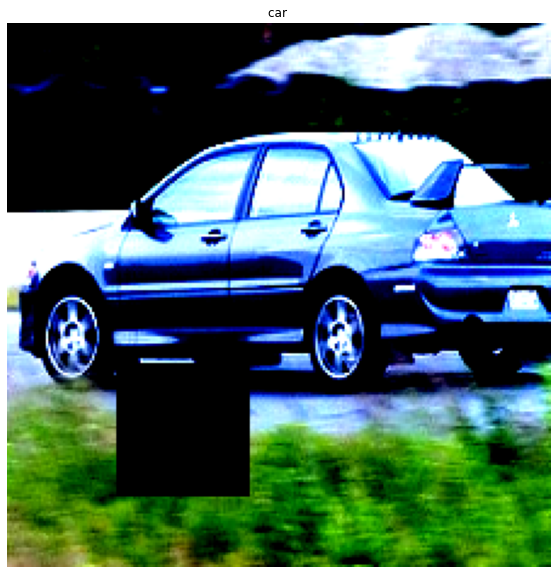

In [77]:
# Test dataset
image, labellist = image_datasets['train'][3]
image = image.permute(1, 2, 0).clamp(0, 1)
plt.figure(figsize=(10, 10))
plt.imshow(image)
title = ""
for i, label in enumerate(labellist):
    title += labels[i] + " " if label == 1 else ""
plt.title(title)
plt.axis('off')
plt.show()

In [78]:
# DataLoader
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)
}

# Test DataLoader
examples = iter(dataloaders['train'])
example_images, example_labellists = examples.next()
print('Batch image size: ', example_images.shape)
print('Batch label size: ', example_labellists.shape)

Batch image size:  torch.Size([32, 3, 224, 224])
Batch label size:  torch.Size([32, 20])


### 5. Define model

In [94]:
pretrained_model = models.resnet50(pretrained=True)

class FinetunedResnet50(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.pretrained_model = pretrained_model
        
        self.num_classes = num_classes
        
        # Finetune
        in_features = self.pretrained_model.fc.in_features
        self.pretrained_model.fc = nn.Linear(in_features, 128)
        self.fc_head = nn.Linear(128, self.num_classes)
        
    def forward(self, x):
        x = F.relu(self.pretrained_model(x))
        x = torch.sigmoid(self.fc_head(x))
        return x
    
model = FinetunedResnet50(pretrained_model, num_classes=len(labels)).to(device)

# Add model graph to Tensorboard
writer.add_graph(model, example_images.to(device))

print(model)

FinetunedResnet50(
  (pretrained_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

### 6. Loss and Optimizer

In [95]:
learning_rate = 0.001
momentum = 0.9
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# scheduler: halve lr every 5 steps
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

### 7. Train model

In [96]:
# train function
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, writer):
    since = time.time()
    
    # Best performance
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # For early stopping
    patience = 0 
    MAX_PATIENCE = 10
    
    for epoch in range(num_epochs):
        time.sleep(1)
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            
            print(f'---- Phase {phase} ----')
            # config model
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # Train info
            running_loss = torch.tensor(0.0).to(device)
            running_corrects = torch.zeros(len(labels)).to(device)
            running_total = torch.zeros(len(labels)).to(device)
            
            # Iterate data
            for i, (images, labellists) in enumerate(dataloaders[phase]):
                
                # To GPU
                images = images.to(device)
                labellists = labellists.to(device)
                
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # Forward pass
                    outputs = model(images)
                    preds = outputs.round()
                    loss = criterion(outputs, labellists)
                    
                    # Backward pass + Update params (training phase only)
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labellists.data, dim=0)
                running_total += labellists.size(0)
                
                # Logging
                if (i + 1) % 20 == 0:
                    print(f'- Iteration {i + 1} / {math.ceil(len(dataloaders[phase].dataset) / images.size(0))}')
                
            # Update learning rate in training phase
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / running_total.sum()
            epoch_cls_acc = running_corrects.double() / running_total * 100
            epoch_acc = epoch_cls_acc.mean()

            # Logging
            print(f'---> Loss: {epoch_loss:.6f} Acc: {epoch_acc:.2f}%\n')
            writer.add_scalar("{}/loss".format(phase), epoch_loss, epoch)
            writer.add_scalar("{}/accuracy/average".format(phase), epoch_acc, epoch)

            # Checkpoint
            if phase == 'val'and epoch_acc > best_acc:
                print('----> Update best accuracy from {:.2f}% to {:.2f}%'.format(best_acc, epoch_acc))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                patience = 0
                
        if epoch_acc < best_acc:
            patience += 1
            if patience >= MAX_PATIENCE:
                break
        
        print()
        
    time_elapsed = time.time() - since
    print(f'Best valid accuracy: {best_acc:.2f}')
    print(f'Training complete in {time_elapsed//3600:.0f}h {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    
    # Load best model
    model.load_state_dict(best_model_wts)
    return model

In [97]:
model = train_model(model, dataloaders, criterion, optimizer, lr_scheduler, num_epochs, writer)
writer.close()

Epoch 1/50
----------
---- Phase train ----
- Iteration 20 / 79
- Iteration 40 / 79
- Iteration 60 / 79
---> Loss: 0.027456 Acc: 83.65%

---- Phase val ----
- Iteration 20 / 79
- Iteration 40 / 79
- Iteration 60 / 79
---> Loss: 0.018403 Acc: 91.35%

----> Update best accuracy from 0.00% to 91.35%

Epoch 2/50
----------
---- Phase train ----
- Iteration 20 / 79
- Iteration 40 / 79
- Iteration 60 / 79
---> Loss: 0.014665 Acc: 91.92%

---- Phase val ----
- Iteration 20 / 79
- Iteration 40 / 79
- Iteration 60 / 79
---> Loss: 0.012585 Acc: 92.34%

----> Update best accuracy from 91.35% to 92.34%

Epoch 3/50
----------
---- Phase train ----
- Iteration 20 / 79
- Iteration 40 / 79
- Iteration 60 / 79
---> Loss: 0.012502 Acc: 92.06%

---- Phase val ----
- Iteration 20 / 79
- Iteration 40 / 79
- Iteration 60 / 79
---> Loss: 0.012028 Acc: 92.33%


Epoch 4/50
----------
---- Phase train ----
- Iteration 20 / 79
- Iteration 40 / 79
- Iteration 60 / 79
---> Loss: 0.012192 Acc: 92.13%

---- Phase va

### 8. View Tensorboard

In [2]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6009/ (Press CTRL+C to quit)
^C


### 9. Evaluate model

In [98]:
since = time.time()

# Convert to eval model
model.eval()

# Train info
running_loss = torch.tensor(0.0).to(device)
running_corrects = torch.zeros(len(labels)).to(device)
running_total = torch.zeros(len(labels)).to(device)


for images, labellists in dataloaders['test']:
    # To GPU
    images = images.to(device)
    labellists = labellists.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.round()
        loss = criterion(outputs, labellists)
        
    # Statistics
    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(preds == labellists.data, dim=0)
    running_total += labellists.size(0)
    
loss = running_loss / running_total.sum()
cls_loss = running_corrects.double() / running_total * 100
acc = cls_loss.mean()

print('Finish testing after {:.2f}s'.format(time.time() - since))
print('Loss: {:.4f} - Acc: {:.2f}%'.format(loss, acc))

Finish testing after 22.22s
Loss: 0.0108 - Acc: 93.42%


### 10. Visualize

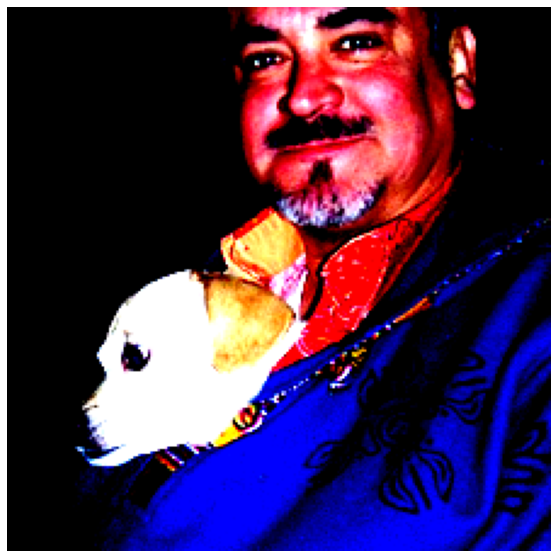

In [104]:
# Test image
image, labellist = image_datasets['test'][0]
plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.show()

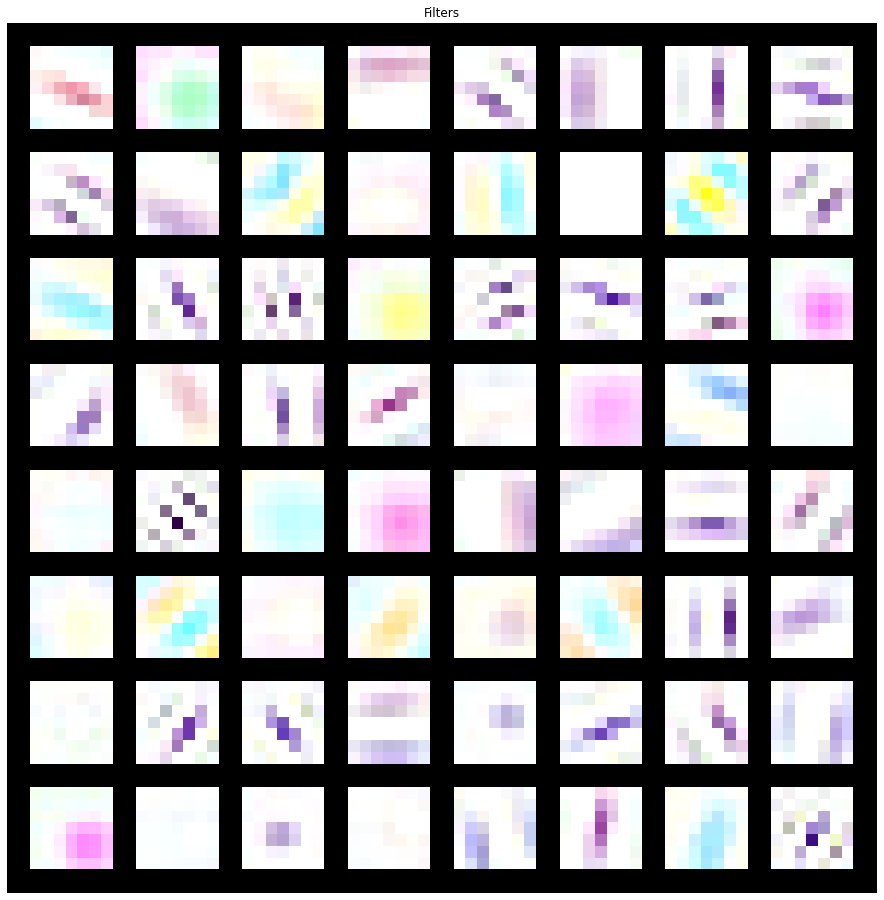

In [146]:
# Visualize early kernels
kernels = model.pretrained_model.conv1.weight.detach().cpu()

# Min max scale
kernels = (kernels - kernels.min()) / kernels.max()
filters = torchvision.utils.make_grid(kernels.clamp(0, 1))
writer.add_image('filters', filters)
filters = filters.permute(1, 2, 0)

plt.figure(figsize=(16, 16))
plt.imshow(filters)
plt.savefig(os.path.join(save_dir, 'filters.jpg'), bbox_inches='tight')
plt.axis('off')
plt.title('Filters')
plt.show()

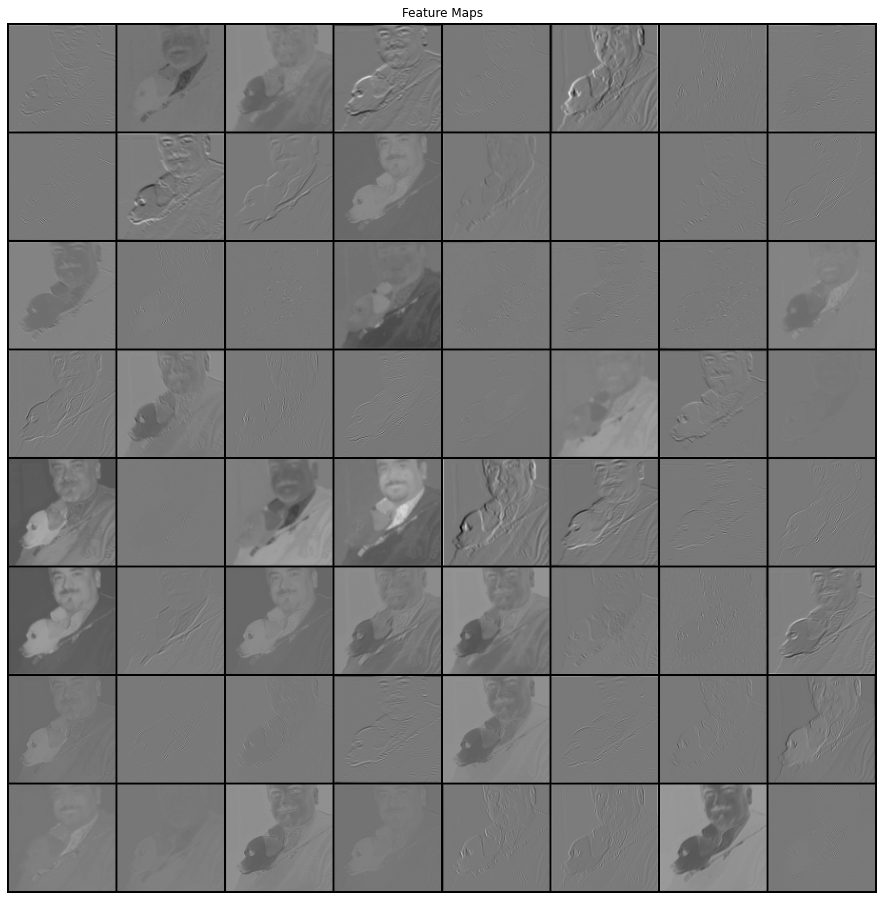

In [142]:
# Visualize feature maps
kernels = model.pretrained_model.conv1.weight.detach().cpu()

class FirstConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2)
    
    def forward(self, x):
        x = self.conv(x)
        return x
    
conv = FirstConv()
conv.conv.weight = nn.Parameter(kernels)
feature_maps = conv(image.unsqueeze(0)).detach()
# Min max scale
feature_maps = (feature_maps - feature_maps.min()) / feature_maps.max()
feature_maps = feature_maps[0].unsqueeze(1)

feature_grid = torchvision.utils.make_grid(feature_maps)
writer.add_image('feature maps', feature_grid)
feature_maps = feature_maps.numpy()

plt.figure(figsize=(16, 16))
plt.imshow(feature_grid[0], cmap='gray')
plt.axis('off')
plt.title('Feature Maps')
plt.show()


### 11. Save model

In [99]:
# Save
torch.save(model.state_dict(), os.path.join(save_dir, 'finetune_resnet50_weights.pth'))

In [100]:
# Load
# model = FinetunedResnet50(pretrained_model, len(labels))
# model.load_state_dict(torch.load(os.path.join(save_dir, 'finetune_resnet50_weights.pth')))
